# Notebook 2 - Design of inhibitors against histamine H1 receptor

By Vincent Blay, November 2021

In this notebook, we demonstrate the use of MACAW embeddings to model binding affinity to a protein receptor of pharmacological interest. MACAW embeddings are then applied to identify promising candidate molecules in a custom virtual library.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.svm import SVR
from sklearn_rvm import EMRVR

#Needed to show molecules
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole 

import macaw
print(macaw.__version__)
from macaw import *

%run "./plotting.py"

0.1.13


In [4]:
%config InlineBackend.figure_format = 'retina'

## 1. Binding to histamine H1 receptor

### 1.1 Data preparation

In [5]:
df = pd.read_csv("./data/data_H1.csv")
Y = df.pKi
smiles = df.Smiles
df.head()

,ID,compound_id,Smiles,pKi
0,1,CHEMBL3925977,O=C(O)c1ccc2cccnc2c1N1CCN(CCc2ccc(OCCCN3CCCCCC...,5.599999
1,2,CHEMBL2171045,O=C(NS(=O)(=O)c1cccc(C(F)(F)F)c1)N1CCC(N2CCC(O...,7.400008
2,3,CHEMBL3753784,COc1ccc(CNc2nc(N3CCN(C)CC3)nc3c2CCc2ccccc2-3)c...,5.200000
3,4,CHEMBL3917794,O=C(O)c1ccc2cccc(N3CCN(CCc4ccc(OCCCN5CCCCCC5)c...,6.599998
4,5,CHEMBL240394,O=C(c1cc(F)cc(F)c1)N1CCN(c2ccc(OCCCN3CCCCC3)cc...,5.700001


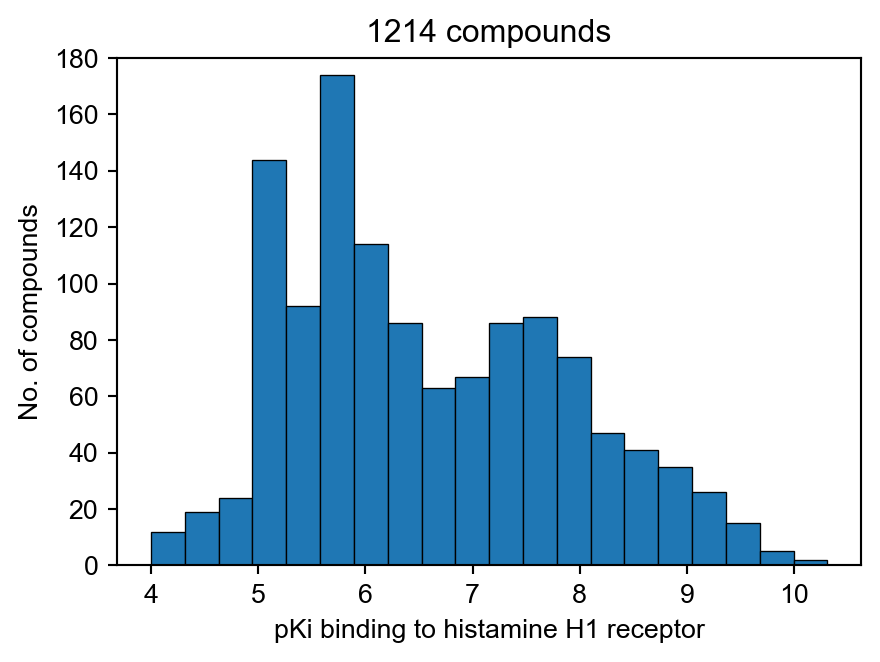

In [6]:
plot_histogram(Y, xlabel="pKi binding to histamine H1 receptor")

In [7]:
smi_train, smi_test, y_train, y_test = train_test_split(smiles, Y, test_size=0.2, random_state=42)

### 1.2 Compute MACAW embeddings

In [8]:
mcw = MACAW(type_fp='atompairs', metric='sokal', n_components=15, n_landmarks=200, random_state=39)
mcw.fit(smi_train, y_train)

In [9]:
X_train = mcw.transform(smi_train)
X_train.shape

(971, 15)

In [10]:
X_test = mcw.transform(smi_test)
X_test.shape

(243, 15)

### 1.3 Modeling using a SVR

In [11]:
for C in [1,3,5,7,10,30,50]:
    regr = SVR(kernel='rbf', C=C, epsilon=.1)
    scores = cross_val_score(regr, X_train, y_train, cv = 5)
    print(scores.mean())

0.7262209194566902
0.7431390610059909
0.7442875763391095
0.7452071432541338
0.7446444353537112
0.7212851361961159
0.6906376895208772


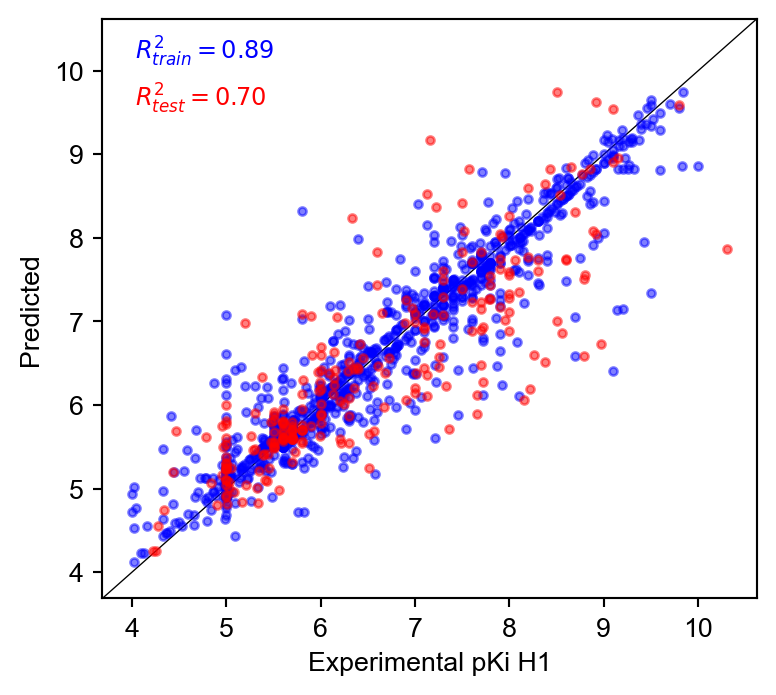

In [12]:
regr = SVR(kernel='rbf', C=10, epsilon=.1)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train,y=y_train_pred,x_test=y_test,y_test=y_test_pred, 
            xlabel="Experimental pKi H1", savetitle="./results/macaw/H1_SVR.svg")

## 2. Binding to muscarinic receptor M2

### 2.1 Data preparation

In [13]:
df = pd.read_csv("./data/data_M2.csv")
Y = df.pKi
smiles = df.Smiles
df.head()

,ID,compound_id,Smiles,pKi
0,1,CHEMBL358493,C[N+]12CCC(CC1)C(O)(c1cc3ccccc3o1)C2,5.259637
1,2,CHEMBL343236,c1ccc2c(c1)CC(C1CN3CCC1CC3)O2,6.309894
2,3,CHEMBL150845,CC(=C1CCN(C2CCN(C(=O)c3ccc(F)c4ccccc34)CC2)CC1...,8.017729
3,4,CHEMBL593871,C[C@H]1OC[C@@H](C[N+](C)(C)C)O[C@@H]1C,4.780000
4,5,CHEMBL91404,CCOC(=O)N1CCC(N2CCC(C(=O)c3ccc(S(=O)(=O)c4ccc5...,9.886057


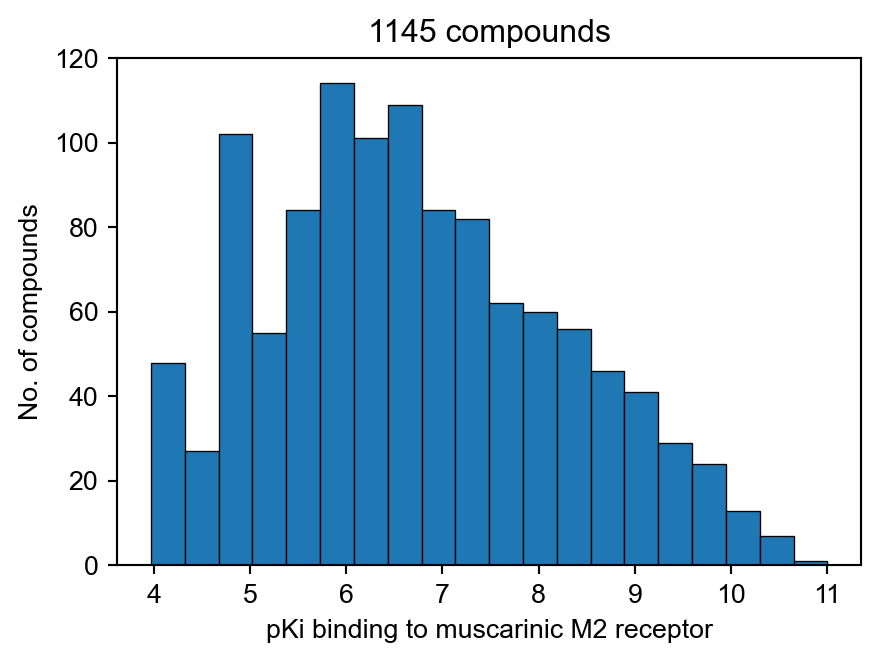

In [14]:
plot_histogram(Y, xlabel="pKi binding to muscarinic M2 receptor")

In [15]:
smi_train, smi_test, y_train, y_test = train_test_split(smiles, Y, test_size = 0.2, random_state = 42)

In [16]:
len(smi_train)

916

### 2.2 Compute MACAW embeddings

In [17]:
mcw2 = MACAW_optimus(smi_train, y= y_train, C=5, verbose=True, n_landmarks=200, exhaustiveness=1, random_state=41)

Problem type identified as regression
morgan2 & tanimoto: 0.589
morgan3 & tanimoto: 0.566
rdk5 & tanimoto: 0.612
rdk7 & tanimoto: 0.597
featmorgan2 & tanimoto: 0.529
featmorgan3 & tanimoto: 0.503
maccs & tanimoto: 0.594
avalon & tanimoto: 0.581
atompairs & tanimoto: 0.657
torsion & tanimoto: 0.605
pattern & tanimoto: 0.586
secfp6 & tanimoto: 0.533
layered & tanimoto: 0.611
atompairs & tanimoto: 0.657
atompairs & cosine: 0.675
atompairs & dice: 0.671
atompairs & sokal: 0.650
atompairs & kulczynski: 0.662
atompairs & mcconnaughey: 0.662
atompairs & braun-blanquet: 0.635
atompairs & rogot-goldberg: 0.664
atompairs & asymmetric: 0.623
atompairs & manhattan: 0.623
atompairs & blay-roger: 0.634
Setting recommended combination: atompairs & cosine


In [18]:
X_train = mcw2.transform(smi_train)
print(X_train.shape)

X_test = mcw2.transform(smi_test)
print(X_test.shape)

(916, 15)
(229, 15)


### 2.3 Modeling using a SVR

In [19]:
for C in [1,3,5,10,30]:
    regr2 = SVR(kernel='rbf', C=C, epsilon=.3)
 
    scores = cross_val_score(regr2, X_train, y_train, cv = 5)
    print(scores.mean())

0.6842332954890107
0.7135315774143101
0.7220152508908789
0.723243333784869
0.7098492292188643


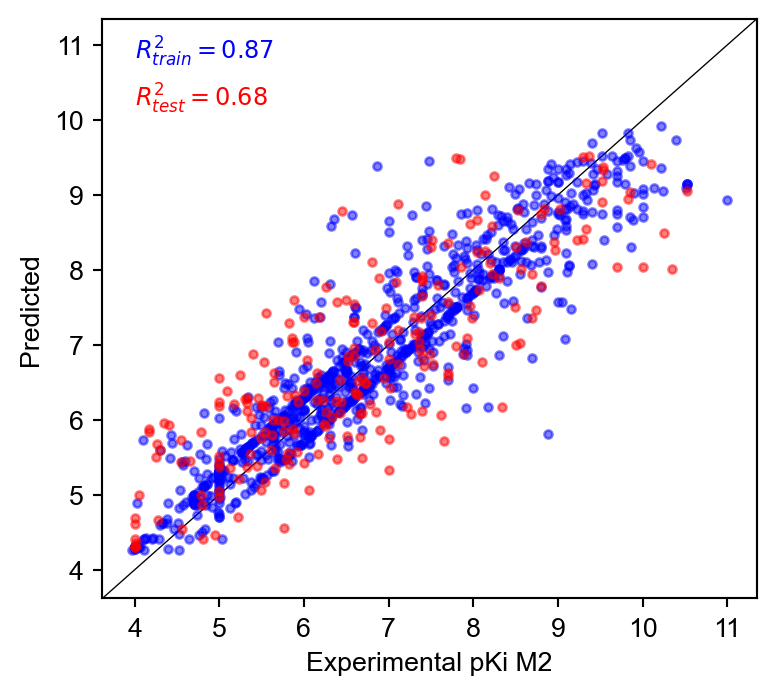

In [20]:
regr2 = SVR(kernel='rbf', C=10, epsilon=.3)
regr2.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr2.predict(X_train)

# Test set predictions
y_test_pred = regr2.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred, 
            xlabel="Experimental pKi M2", savetitle="./results/macaw/M2_SVR.svg")

## 3. Discovery of new hits specific to H1

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` and `regr2` above, which use 15-D MACAW embeddings as their input. The custom library ("LibraryVB.csv") is a custom library compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted binding affinity to the H1 receptor and comparatively low predicted binding affinity to the M2 receptor.

In [21]:
mylib = pd.read_csv("./data/LibraryVB.csv")
print(mylib.shape)
mylib.head()

(19490, 2)


,Smiles,Source
0,NC(=O)NC(=O)Cn1c(=O)c(C#N)cn(C2CC2)c1=O,Enamine_antivirals
1,CC(C)CNC(=O)Cn1c(=O)c(C#N)cn(C2CC2)c1=O,Enamine_antivirals
2,O=C(Cn1cccnc1=O)NC1CCCCCC1,Enamine_antivirals
3,CCC(=O)Nc1ccc(cn1)N1CCOCC1,Enamine_antivirals
4,Cc1nn(C)c(C)c1CC(=O)NC(C1CC1)C1CC1,Enamine_antivirals


In [22]:
smi_lib = mylib.Smiles

In [23]:
X1_lib = mcw.transform(smi_lib)

Y1_lib_pred = regr.predict(X1_lib)

In [24]:
X2_lib = mcw2.transform(smi_lib)

Y2_lib_pred = regr2.predict(X2_lib)

Let us represent the predictions of both models:

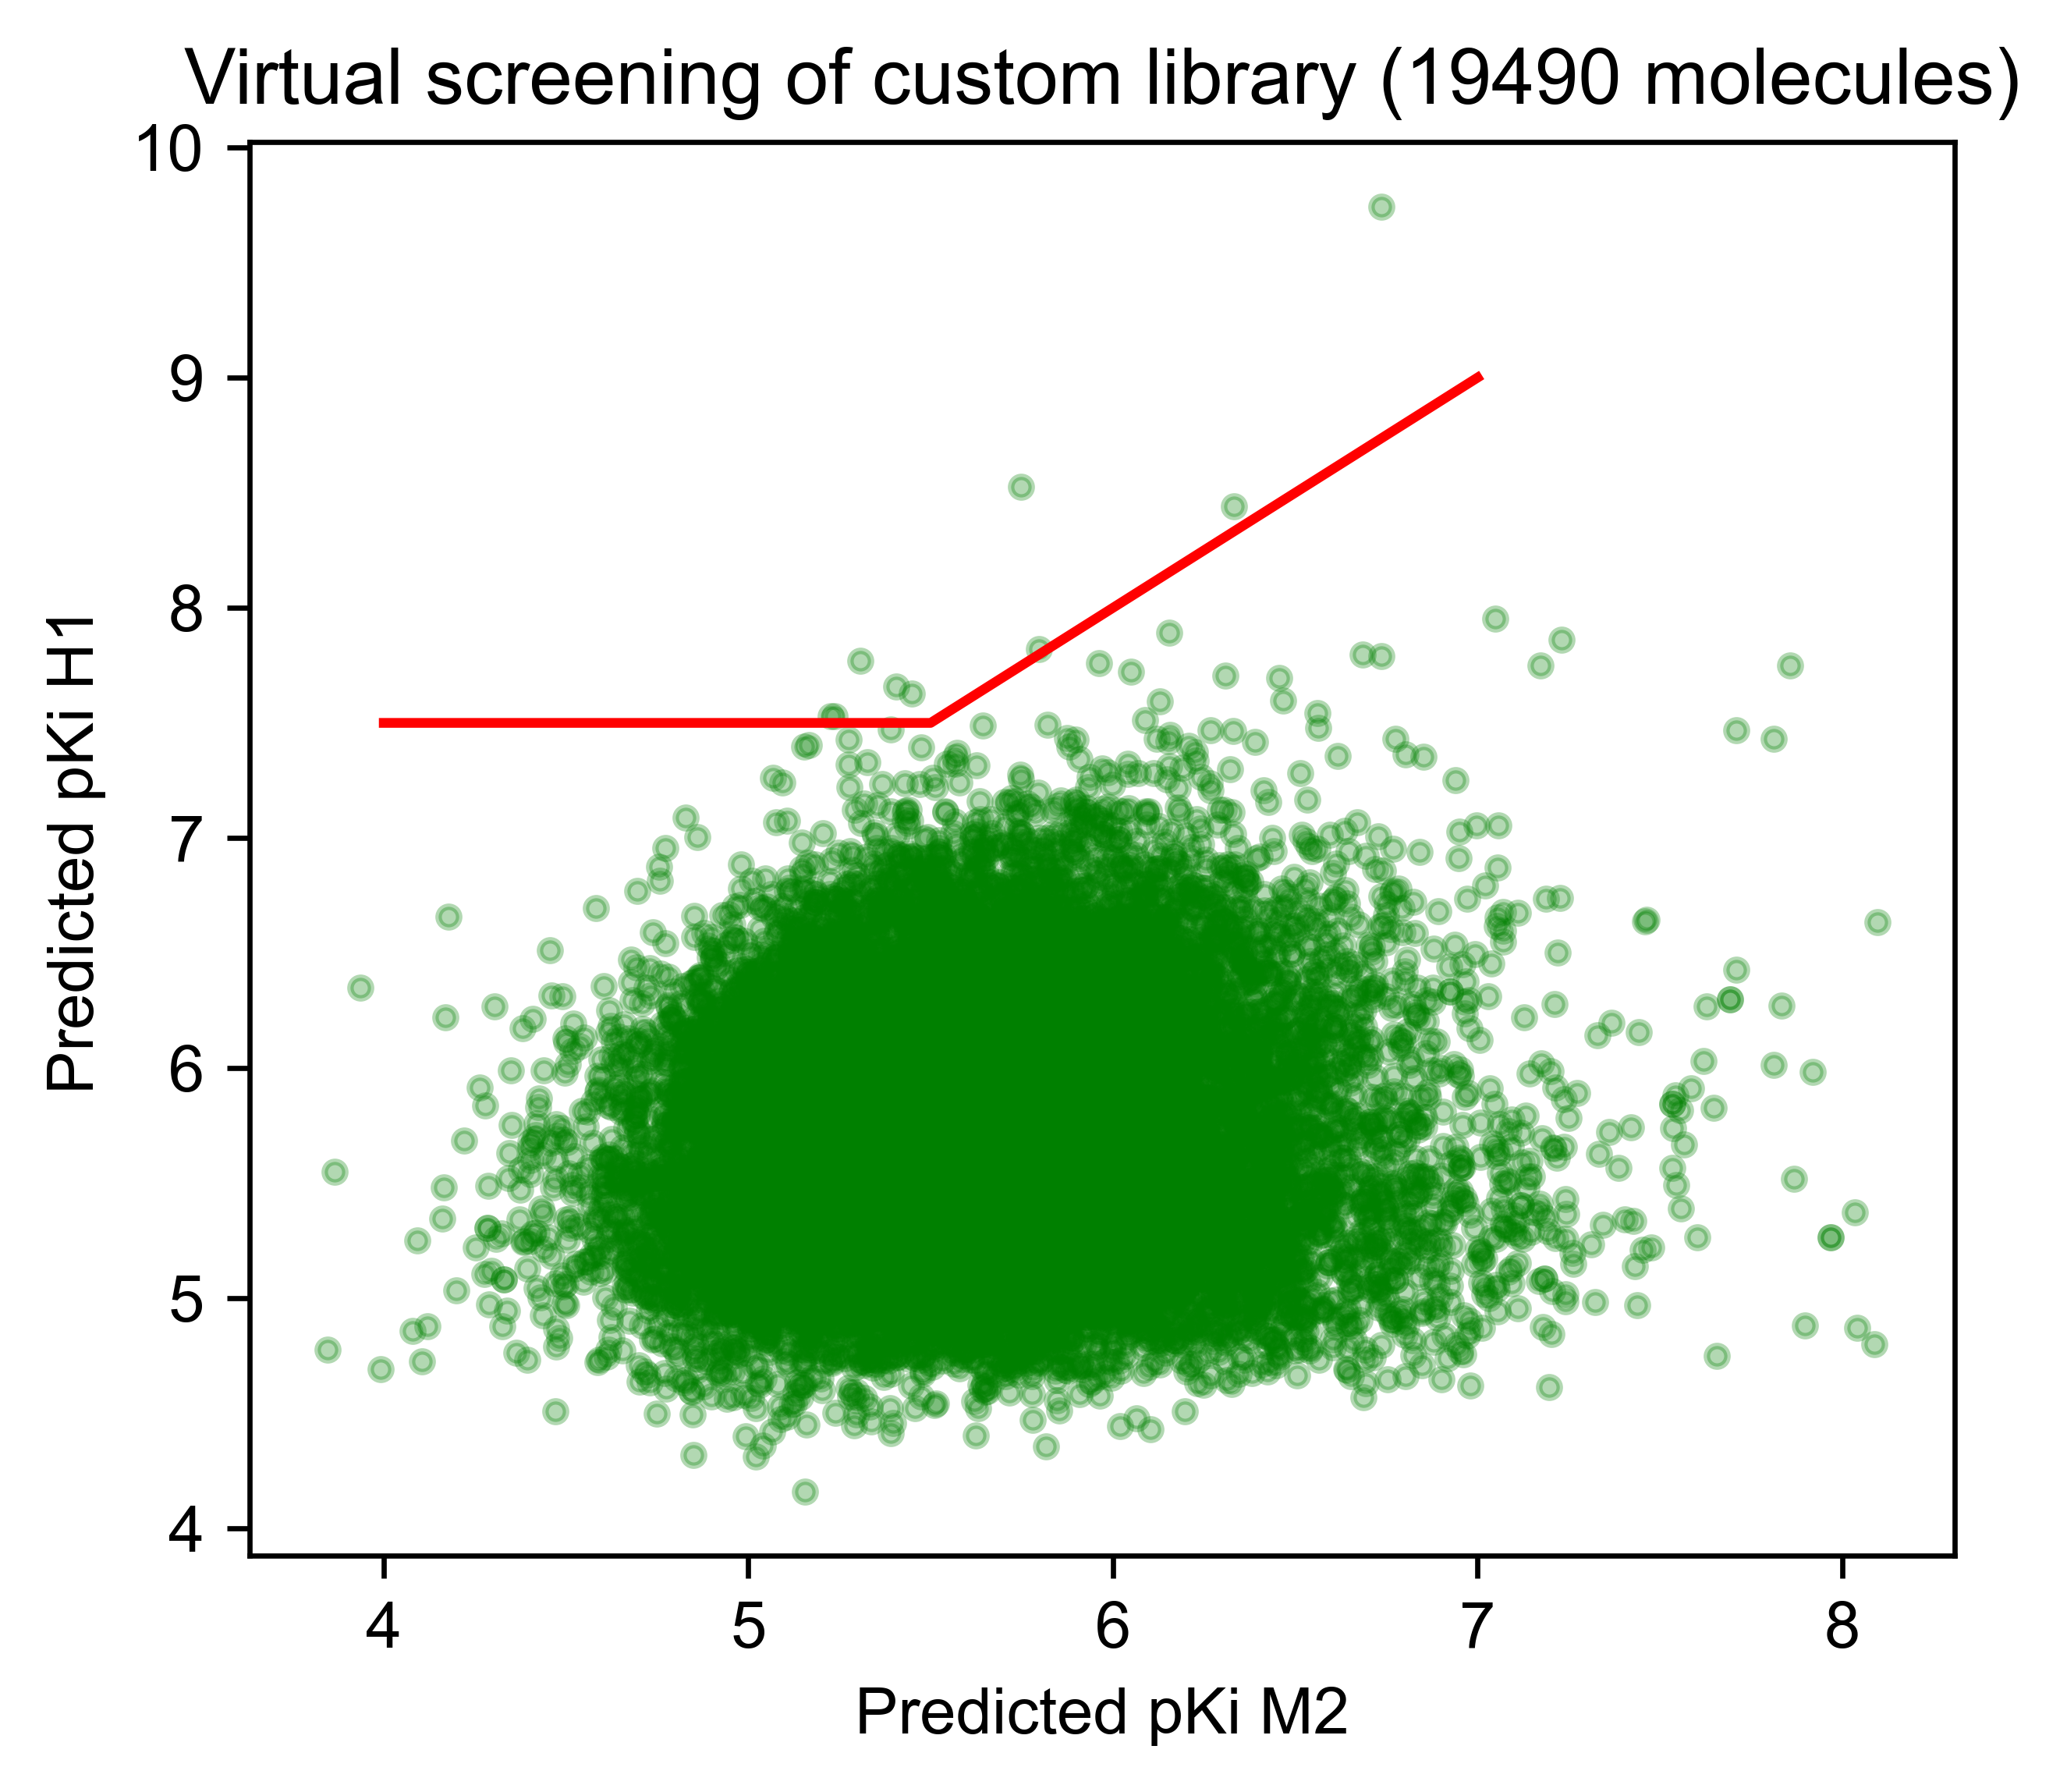

In [25]:
plt.figure(figsize=(4.7,4.0), dpi=300)
plt.scatter(x=Y2_lib_pred,y=Y1_lib_pred, s=10, c='green', alpha=0.3) 
plt.xlabel("Predicted pKi M2")
plt.ylabel("Predicted pKi H1")
plt.title(f"Virtual screening of custom library ({len(smi_lib)} molecules)")
plt.plot([4,5.5,7],[7.5,7.5,9],c='red')
plt.savefig("./results/macaw/H1_library_screening.svg", bbox_inches='tight', dpi=300)

Let us have a look at the compounds:

In [26]:
idx = np.where((Y1_lib_pred > 7.5)*(Y1_lib_pred > (Y2_lib_pred + 2.)))[0]

In [27]:
lead_df = mylib.iloc[idx].copy()
lead_df['pKi_H1_pred'] = Y1_lib_pred[idx]
lead_df['pKi_M2_pred'] = Y2_lib_pred[idx]

lead_df

,Smiles,Source,pKi_H1_pred,pKi_M2_pred
249,CC(=O)NCCc1nc2ccccc2n1CCOc1ccccc1,Enamine_antivirals,7.626558,5.448142
4910,CO[C@@H]1C[C@H](N(Cc2ccc3ccccc3n2)C1)c1nnc2CCCn12,Enamine_DDS1720,7.530099,5.236325
7432,COC(=O)C1CCc2nnc(Cc3ccc4ccccc4c3)n2CC1,Enamine_DDS4242,7.527884,5.225078
9050,COC(=O)C1CCc2nnc(CCc3ccccc3)n2C1,Enamine_DDS5860,7.659310,5.406420
13946,CN(C)CC/C=C\1/c2ccccc2COc2ccccc12,Enamine_Phenotypic,9.743297,6.736542
17620,COc1ccc(cc1)c1cn2CCCCCc2[n+]1c1ccccc1,Enamine_Phenotypic,7.820498,5.797327
17743,C(c1ccccc1)n1c(nc2ccccc12)N1CCNCC1,Enamine_Phenotypic,7.770770,5.308004
19111,CN(C)CCCN1c2ccccc2Sc2ccc(Cl)cc12,Enamine_Phenotypic,8.439743,6.332405
19341,CN(C)CC/C=C\1/c2ccccc2Sc2ccc(Cl)cc12,Enamine_Phenotypic,8.526045,5.747269


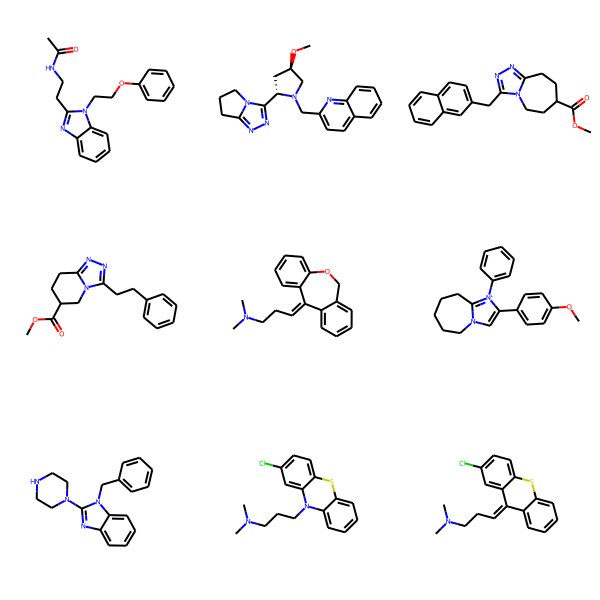

In [34]:
molecules = [Chem.MolFromSmiles(smi) for smi in lead_df.Smiles[:50]]

Draw.MolsToGridImage(molecules, subImgSize=(200,200), molsPerRow=3, useSVG=True)